# 1. Layers
### 1.1. Conv Layer

In [16]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

def cls():
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()

In [17]:
from sklearn.datasets import load_sample_images

images = load_sample_images()
images.keys()

dict_keys(['images', 'filenames', 'DESCR'])

In [18]:
images = images['images'] # It return 2 images
print("Original shape: ", images[0].shape)
images = tf.keras.layers.CenterCrop(70,120)(images)
images = tf.keras.layers.Rescaling(1/255)(images)
images.shape

Original shape:  (427, 640, 3)


TensorShape([2, 70, 120, 3])

In [20]:
cls()
cl = tf.keras.layers.Conv2D(filters=32, kernel_size=7) # 32*7*7*3
fmaps = cl(images)
fmaps.shape

TensorShape([2, 64, 114, 32])

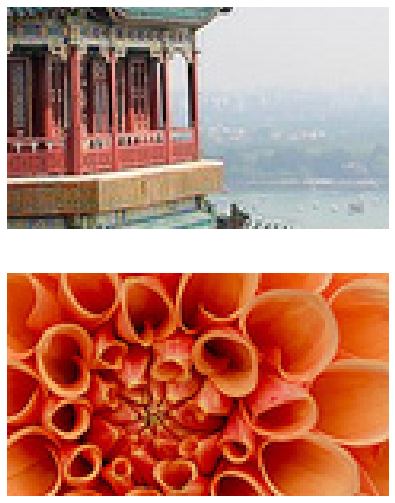

In [42]:
# Displaying original image
plt.figure(figsize=(15, 9))
for image_idx in range(images.shape[0]):
    plt.subplot(2,1,image_idx+1)
    plt.imshow(images[image_idx])
    plt.axis("off")

plt.show()

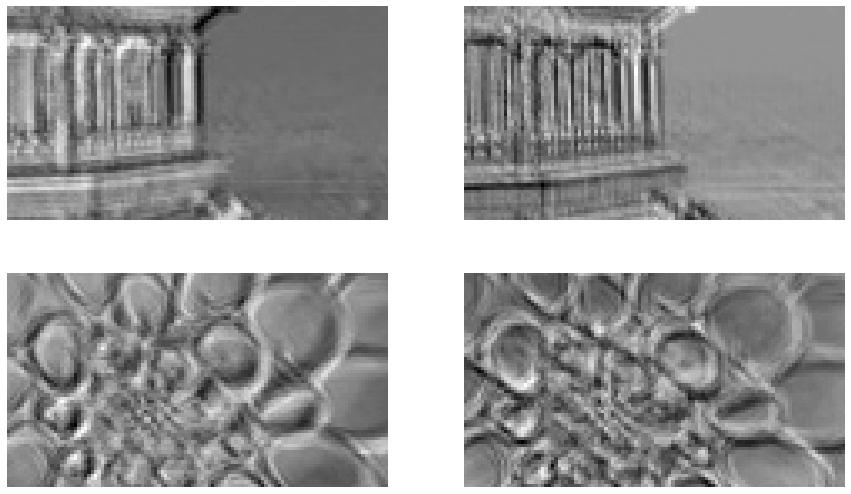

In [46]:
#displays the two output feature maps for each image
plt.figure(figsize=(15, 9))
for image_idx in range(fmaps.shape[0]):
    for fmap_idx in range(fmaps.shape[-1]-30): # only two filters showing
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

As we can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

In [50]:
# Without zero padding
print("Image shape : ",images.shape)
fmaps = tf.keras.layers.Conv2D(32,7)(images)
fmaps.shape

Image shape :  (2, 70, 120, 3)


TensorShape([2, 64, 114, 32])

In [51]:
# Using zero padding
print("Image shape : ",images.shape)
fmaps = tf.keras.layers.Conv2D(32,7,padding='same')(images)
fmaps.shape

Image shape :  (2, 70, 120, 3)


TensorShape([2, 70, 120, 32])

In [55]:
# Using Stride=2  Image size will reduce
print("Image shape : ",images.shape)
fmaps = tf.keras.layers.Conv2D(32,7,padding='same',strides=2)(images)
fmaps.shape

Image shape :  (2, 70, 120, 3)


TensorShape([2, 35, 60, 32])

In [56]:
# this utility function can be useful to compute the size of the
# feature maps output by a convolutional layer. It also returns
# the number of ignored rows or columns if padding="valid", or the
#  number of zero-padded rows or columns if padding="same"
# Z = ((N + 2P - F)/S) + 1

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")


(array([35, 60], dtype=int32), array([5, 5]))

In [59]:
conv_layer = tf.keras.layers.Conv2D(32, 7, padding='same',strides=2)
fmaps = conv_layer(images)
kernels, biases = conv_layer.get_weights()
kernels.shape, biases.shape
# 7*7*3 represent as a single neuron we have 32 here + 32 bias terms

((7, 7, 3, 32), (32,))

In [63]:
#shows how to use the tf.nn.conv2d() operation
# This is low level API. we manually assign filter. If we want to 
cls()
filters = tf.random.normal([7, 7, 3, 2]) # 2 neurons 
biases = tf.zeros([2]) # two bias
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases
fmaps.shape

TensorShape([2, 70, 120, 2])

Let's manually create two filters full of zeros, except for a vertical line of 1s in the first filter, and a horizontal one in the second filter (just like in Figure 14–5). The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice you will probably never need to create filters manually, since the convolutional layers will learn them automatically.

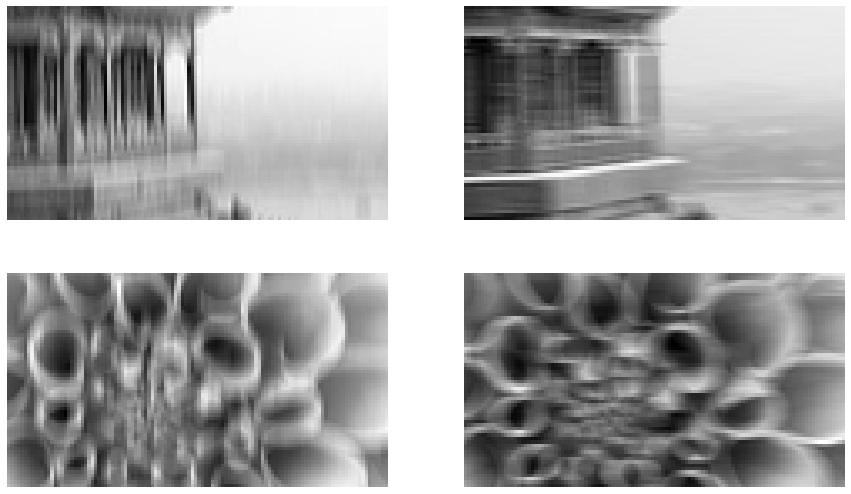

In [77]:
# With valid padding
cls()
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1 # Vertical edge detector
filters[3, :, :, 1] = 1 # Horizontal edge detector
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="VALID")  + biases
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

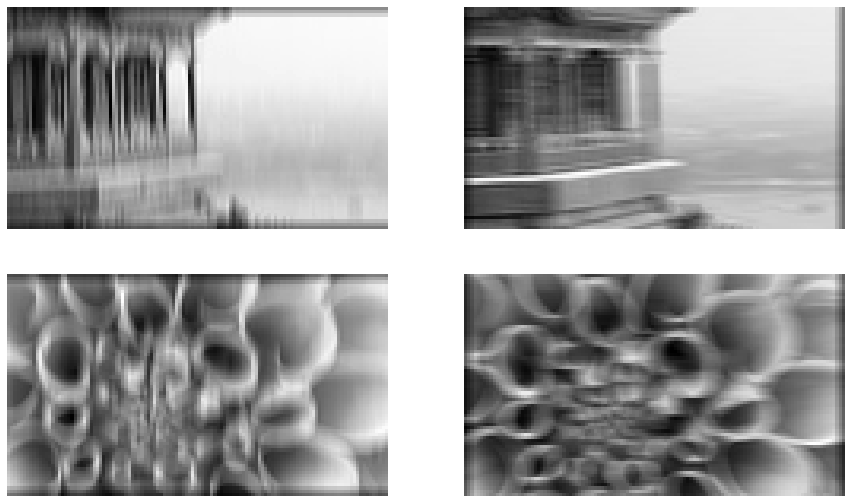

In [78]:
# With Same padding
cls()
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1 # Vertical edge detector
filters[3, :, :, 1] = 1 # Horizontal edge detector
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME")  + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figure?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

### 1.2. Pooling Layer